In [1]:
import sys
sys.path.append('..')
# folder = os.getcwd().split("\notebooks")[0]
from transport_frames.graphbuilder.graph import Graph 
from transport_frames.frame_grader.advanced_grade import AdvancedGrader
from transport_frames.framebuilder.frame import Frame
import transport_frames.utils.helper_funcs as he
from transport_frames.utils.adj_calc import AdjacencyCalculator
from transport_frames.indicators.indicator_terr import indicator_territory

from transport_frames.indicators.indicator_area import indicator_area, preprocess_service_accessibility
import osmnx as ox
import geopandas as gpd
import networkx as nx
from shapely import Polygon, MultiPolygon
import momepy
import shapely
from transport_frames.graphbuilder.graph import convert_geometry_from_wkt
import pandas as pd
from blocksnet import BlocksGenerator
import numpy as np
import random
from transport_frames.indicators.utils import get_adj_matrix_gdf_to_gdf



/Users/polina/Desktop/github/transport_frames/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# create blocks from 2 uds

In [ ]:
class UdsSchema(BaseSchema):
    # name: pa.typing.Series[str]
    _geom_types = [LineString]

# Schema for Points (Region Admin Center, District Points, Settlement Points)
class PointsSchema(BaseSchema):
    _geom_types = [Point]

# # Schema for Districts
# class DistrictsSchema(BaseSchema):
#     _geom_types = [Polygon, MultiPolygon]

In [ ]:
def count_effect(uds_before: gpd.GeoDataFrame,
                 uds_after: gpd.GeoDataFrame,
                 houses_before: gpd.GeoDataFrame,
                 houses_after: gpd.GeoDataFrame,
                 services_before:gpd.GeoDataFrame,
                 services_after:gpd.GeoDataFrame,
                 speed: float = 16.667):
    """
    Counts the effect on the territory change.
    """
    # assign speed

    # divide both terrs into blocks using blocksnet

    # find 

In [2]:
roads_before = gpd.read_file('uds_before.geojson').to_crs(32636)

roads_after = gpd.read_file('uds_after.geojson').to_crs(32636)
# coorrect roads_after geometries
merged = roads_after.unary_union
if merged.geom_type == 'MultiLineString':
    roads_after = gpd.GeoDataFrame(geometry=list(merged.geoms),crs = roads_after.crs)
else:
    roads_after = gpd.GeoDataFrame(geometry=[merged],crs = roads_after.crs)

In [3]:
roads_before['weight'] = roads_before.geometry.length / 1000 
roads_after['weight'] = roads_after.geometry.length / 1000 

In [4]:
railways = gpd.read_file('/Users/polina/Desktop/github/transport_frames/data/Ленинградская_область 2/Ленинградская_область_railway_roads.geojson').to_crs(32636)
water = gpd.read_file('/Users/polina/Desktop/github/transport_frames/data/Ленинградская_область 2/Ленинградская_область_water.geojson').to_crs(32636)
boundary = gpd.GeoDataFrame(geometry=[roads_after.unary_union.convex_hull], crs=roads_after.crs)

In [5]:
# bg = BlocksGenerator(
#   boundaries=boundary,
#   water=water,
#   roads=roads_after,
#   railways=railways
# )
# blocks_after= bg.run()
# blocks_after.to_parquet('blocks_after.parquet')
blocks_after = gpd.read_parquet('blocks_after.parquet')


# bg = BlocksGenerator(
#   boundaries=boundary,
#   water=water,
#   roads=roads_before,
#   railways=railways
# )
# blocks_before = bg.run()
# blocks_before.to_parquet('blocks_before.parquet')
blocks_before = gpd.read_parquet('blocks_before.parquet')

In [6]:
# diff = roads_after.geometry.difference(roads_before.unary_union)
# diff=gpd.GeoDataFrame(geometry=diff)
# diff = diff[~diff['geometry'].is_empty]
# diff = diff.drop([4515,4516,4539,4540])

# changed_terr = diff.unary_union.convex_hull
# changed_terr = gpd.GeoDataFrame(geometry=[changed_terr], crs=diff.crs)
# changed_terr.to_parquet('changed_terr.parquet')

changed_terr = gpd.read_parquet('changed_terr.parquet')

# fill with people and services

In [7]:
blocked_terr_before = gpd.sjoin(blocks_before, changed_terr, how="inner", predicate="intersects")
blocked_terr_after = gpd.sjoin(blocks_after, changed_terr, how="inner", predicate="intersects") 

context_before = blocks_before.drop(blocked_terr_before.index)
context_before['area'] = context_before.geometry.area


context_before = context_before.sort_values(by='area').reset_index(names='old_id')
context_before['id'] = context_before.index

context_after = blocks_after.drop(blocked_terr_after.index)
context_after['area'] = context_after.geometry.area
context_after = context_after.sort_values(by='area').reset_index(names='old_id')
context_after['id'] = context_after.index


In [8]:
# Assign context with people 
context_before['people'] = np.random.randint(5, 101, size=(len(context_before)))
ind_to_remove = context_after.loc[context_after.old_id.isin([836, 205, 216, 217, 207, 201, 202, 204, 199, 198, 190, 188, 175, 174])].index
context_before.loc[ind_to_remove, 'people'] = 0
context_after['people'] = context_before['people']

# and services
blocks_with_service = random.sample(list(context_after.index), round(len(context_after)*0.7))
context_after.loc[blocks_with_service,'service'] = 1
context_after['service'] = context_after['service'].fillna(0.0)
context_before['service'] = context_after['service']


In [9]:
# Assign original terr with people
blocked_terr_before['people'] = np.random.randint(0, 5, size=(len(blocked_terr_before)))

# and services
blocks_with_service = random.sample(list(blocked_terr_before.index), round(len(blocked_terr_before)*0.3))
blocked_terr_before.loc[blocks_with_service,'service'] = 1
blocked_terr_before['service'] = blocked_terr_before['service'].fillna(0.0)


In [10]:
# Assign changed terr with new people
blocked_terr_after['people'] = np.random.randint(0, 50, size=(len(blocked_terr_after)))

# and services
blocks_with_service = random.sample(list(blocked_terr_after.index), round(len(blocked_terr_after)*0.5))
blocked_terr_after.loc[blocks_with_service,'service'] = 1
blocked_terr_after['service'] = blocked_terr_after['service'].fillna(0.0)

In [11]:
full_blocks_before = pd.concat([context_before, blocked_terr_before]).reset_index(drop=True)
full_blocks_after = pd.concat([context_after, blocked_terr_after]).reset_index(drop=True)


# extract only living and serviced blocks

In [12]:
living_blocks_before = full_blocks_before[full_blocks_before.people > 0]
living_blocks_after = full_blocks_after[full_blocks_after.people > 0]

serviced_blocks_before = full_blocks_before[full_blocks_before.service == 1]
serviced_blocks_after = full_blocks_after[full_blocks_after.service == 1]

In [13]:
living_blocks_before.geometry = living_blocks_before.representative_point()
living_blocks_after.geometry = living_blocks_after.representative_point()

serviced_blocks_before.geometry = serviced_blocks_before.representative_point()
serviced_blocks_after.geometry = serviced_blocks_after.representative_point()

In [14]:
full_blocks_before.explore('people')

In [15]:
full_blocks_after.explore('people')

# find adjacency

In [16]:
g_before = nx.MultiDiGraph(nx.DiGraph(momepy.gdf_to_nx(roads_before).to_directed()))
g_after = nx.MultiDiGraph(nx.DiGraph(momepy.gdf_to_nx(roads_after).to_directed()))

for node,data in g_before.nodes(data=True):
    data['x'] = node[0]
    data['y'] = node[-1]
for node,data in g_after.nodes(data=True):
    data['x'] = node[0]
    data['y'] = node[-1]


for e1,e2,data in g_before.edges(data=True):
    data['transport_type'] = 'drive'
for e1,e2,data in g_after.edges(data=True):
    data['transport_type'] = 'drive'

g_before.graph['crs'] = g_before.graph['crs'].to_epsg()
g_after.graph['crs'] = g_after.graph['crs'].to_epsg()  

In [17]:
m_before = get_adj_matrix_gdf_to_gdf(living_blocks_before,serviced_blocks_before,g_before,weight='weight',dtype=np.float64)
m_after= get_adj_matrix_gdf_to_gdf(living_blocks_after,serviced_blocks_after,g_after,weight='weight',dtype=np.float64)
# m_before = AdjacencyCalculator(blocks=full_blocks_before.reset_index(drop=True), graph=g_before).get_dataframe()
# m_after = AdjacencyCalculator(blocks=full_blocks_after.reset_index(drop=True), graph=g_after).get_dataframe()


# Min- Max

In [18]:
mask1 = m_before.index.values[:, None] != m_before.columns.values
mask2 = m_after.index.values[:, None] != m_after.columns.values
df_nonzero1 = m_before.replace(0, np.nan)
df_nonzero2 = m_after.replace(0, np.nan)
print("Min time before - ",m_before.where(mask1).min().min()," Min nonzero - ",df_nonzero1.min().min()," max time before - ",m_before.where(mask1).max().max())
print("Min time after - ",m_after.where(mask2).min().min()," Min nonzero - ",df_nonzero2.min().min(), " max time after - ", m_after.where(mask2).max().max())


Min time before -  0.0  Min nonzero -  0.0021542076528238527  max time before -  7.962881362148273
Min time after -  0.0  Min nonzero -  0.001622172182387377  max time after -  7.67112722934341


In [26]:
print('Median before - ',m_before.median().median())
print('Median after - ', m_after.median().median())
effect_koeff_median = m_before.median().median()/m_after.median().median()
effect_koeff_median

Median before -  0.9552903619810993
Median after -  1.113687501262279


0.8577723651368552

In [28]:
print('Mean before - ',m_before.mean().mean())
print('Mean after - ', m_after.mean().mean())
effect_koeff_mean = m_before.mean().mean()/m_after.mean().mean()
effect_koeff_mean

Mean before -  1.7348264117771197
Mean after -  2.1091969884779203


0.8225056366257373

In [30]:
print('Weighted Median before - ',(m_before.median(axis=1) * living_blocks_before['people']).median())
print('Weighted Median after - ',(m_after.median(axis=1) * living_blocks_after['people']).median())
effect_koeff_weighted_median = (m_before.median(axis=1) * living_blocks_before['people']).median()/(m_after.median(axis=1) * living_blocks_after['people']).median()
effect_koeff_weighted_median


Weighted Median before -  51.37670225355308
Weighted Median after -  61.25696666814114


0.8387079061861767

In [31]:
print('Weighted Mean before - ',(m_before.median(axis=1) * living_blocks_before['people']).mean())
print('Weighted Mean after - ',(m_after.median(axis=1) * living_blocks_after['people']).mean())
effect_koeff_weighted_mean = (m_before.median(axis=1) * living_blocks_before['people']).mean()/(m_after.median(axis=1) * living_blocks_after['people']).mean()
effect_koeff_weighted_mean


Weighted Mean before -  66.68174728274762
Weighted Mean after -  75.82353967118048


0.8794333207328814

In [73]:
full_blocks_after = full_blocks_after.loc[living_blocks_after.index]

full_blocks_after['median'] = m_after.median(axis=1)
full_blocks_after['mean'] = m_after.mean(axis=1)
full_blocks_after['weighted_median'] = m_after.median(axis=1) * living_blocks_after['people']
full_blocks_after['weighted_mean'] = m_after.mean(axis=1) * living_blocks_after['people']


full_blocks_before = full_blocks_before.loc[living_blocks_before.index]
full_blocks_before['median'] = m_before.median(axis=1)
full_blocks_before['mean'] = m_before.mean(axis=1)
full_blocks_before['weighted_median'] = m_before.median(axis=1) * living_blocks_before['people']
full_blocks_before['weighted_mean'] = m_before.mean(axis=1) * living_blocks_before['people']


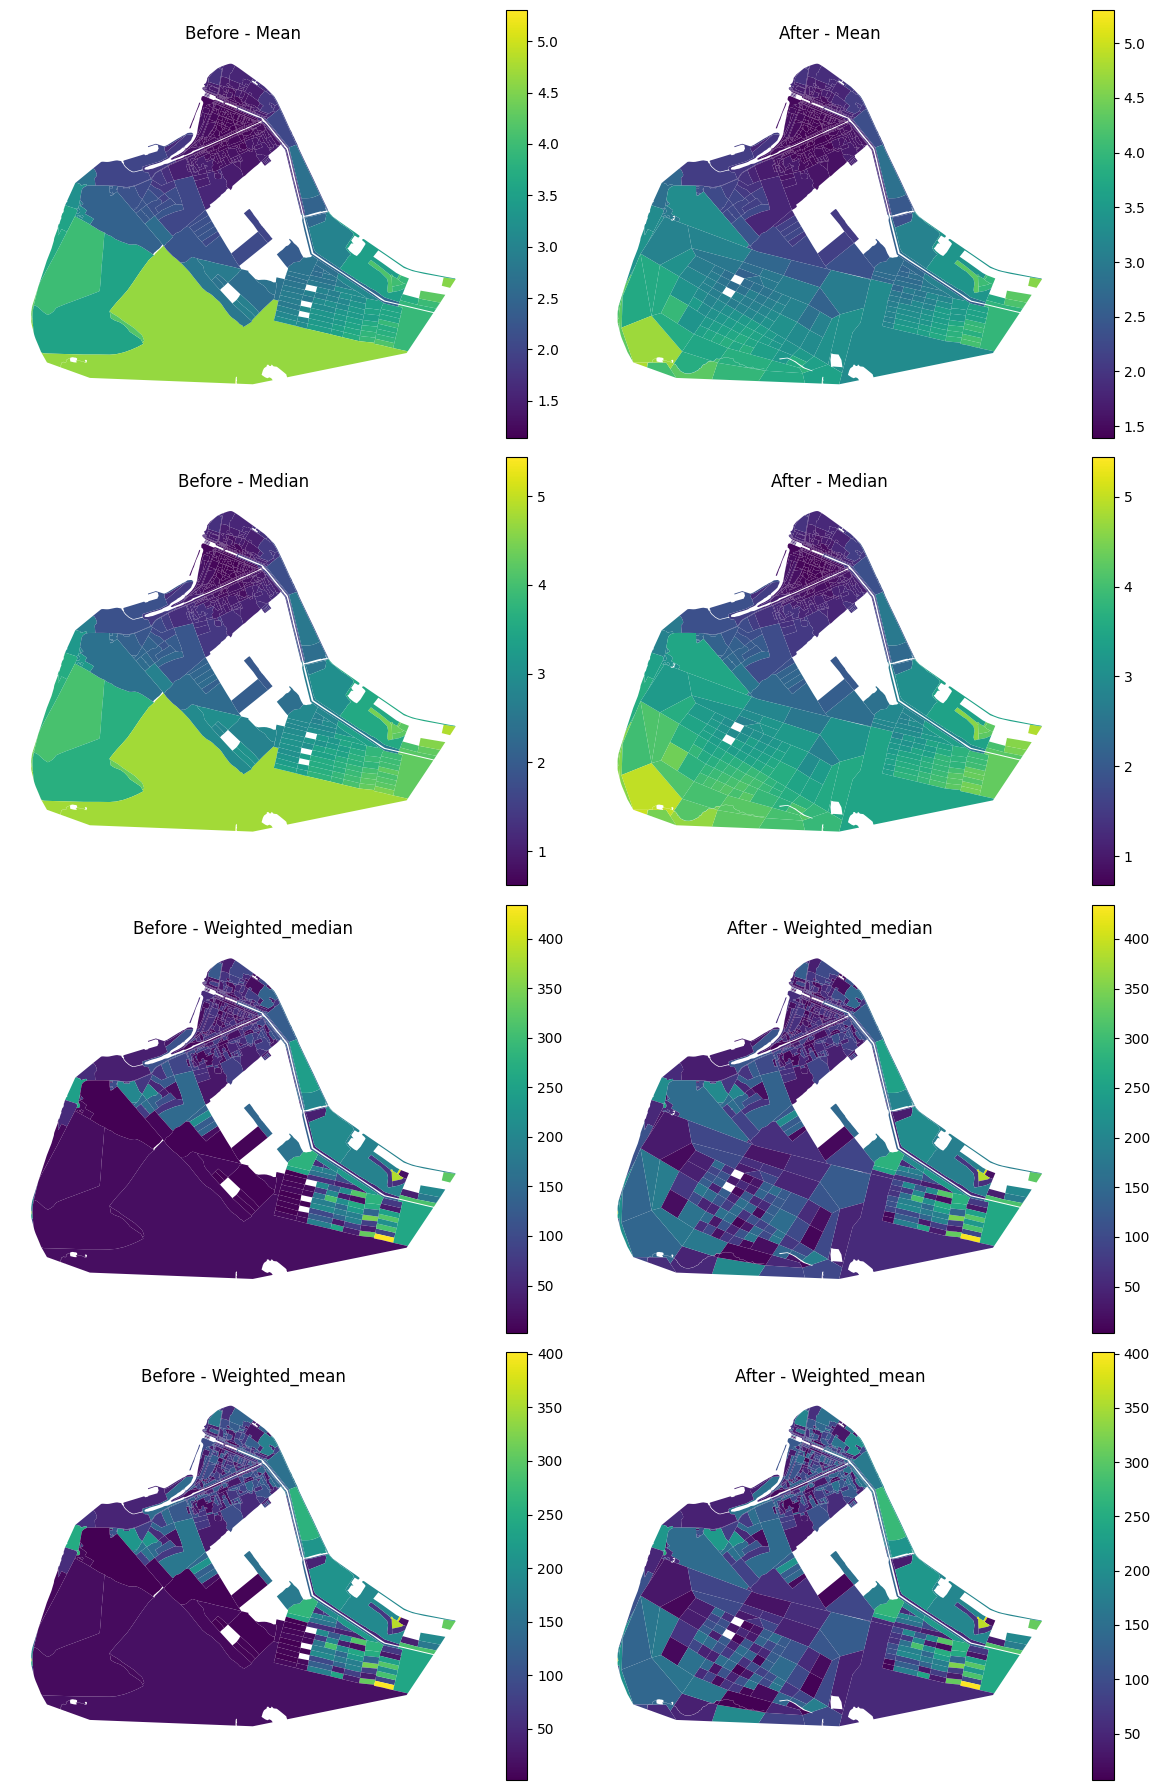

In [76]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load your GeoDataFrames (replace with your own data)
# full_blocks_before = gpd.read_file('path_to_before_shapefile.shp')
# full_blocks_after = gpd.read_file('path_to_after_shapefile.shp')

# Create a figure and axes for the subplots
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 18))

# Define the columns to plot
columns = ['mean', 'median', 'weighted_median', 'weighted_mean']

# Loop through the columns to create the plots
for i, column in enumerate(columns):
    # Calculate vmax as the largest value between before and after
    max_before = full_blocks_before[column].max()
    max_after = full_blocks_after[column].max()
    vmax = max(max_before, max_after)

    # Plot for "before"
    full_blocks_before.plot(column=column, vmax=vmax, legend=True, ax=axs[i, 0])
    axs[i, 0].set_title(f'Before - {column.capitalize()}')
    axs[i, 0].set_axis_off()  # Optional: Turn off the axis for better visualization
    
    # Plot for "after"
    full_blocks_after.plot(column=column, vmax=vmax, legend=True, ax=axs[i, 1])
    axs[i, 1].set_title(f'After - {column.capitalize()}')
    axs[i, 1].set_axis_off()  # Optional: Turn off the axis for better visualization

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()